In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
import os
import sys

import numpy as np
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt

from otf import optim
from otf import time_integration as ti
from otf.system import base as system_base

sys.path.append("..")
import error_surfaces as es

jndarray = jnp.ndarray
ndarray = np.ndarray

FIGURES_FOLDER = os.path.join(os.getcwd(), "figures")
os.makedirs(FIGURES_FOLDER, exist_ok=True)

In [ ]:
def get_initial_values(I, J, J_sim):
    SEED = 42

    # Initial true state
    init = np.random.default_rng(SEED).uniform(size=I + I * J)

    u0 = jnp.array(init[:I])
    v0 = jnp.array(jnp.reshape(init[I:], (I, J)))

    # Initial simulation state
    un0 = jnp.zeros_like(u0)
    vn0 = jnp.zeros((I, J_sim))

    return (
        jnp.concatenate((jnp.expand_dims(u0, axis=1), v0), axis=1),
        jnp.concatenate((jnp.expand_dims(un0, axis=1), vn0), axis=1),
    )


def true_ode(gs: jndarray, true: jndarray) -> jndarray:
    p1, p2 = gs[6:]
    F, ds = gs[0], gs[1:6]

    u, v = true[:, 0], true[:, 1:]

    up = (
        jnp.roll(u, 1) * (jnp.roll(u, -1) - jnp.roll(u, 2))
        + p1 * jnp.sum(u * v.T, axis=0)
        - p2 * u
        + F
    )

    vp = -ds * v - jnp.expand_dims(p1 * u**2, axis=1)

    return jnp.concatenate((jnp.expand_dims(up, axis=1), vp), axis=1)


def assimilated_ode(
    cs: jndarray, assimilated: jndarray, F: float, ds: jndarray
) -> jndarray:
    p1, p2 = cs

    u, v = assimilated[:, 0], assimilated[:, 1:]

    up = (
        jnp.roll(u, 1) * (jnp.roll(u, -1) - jnp.roll(u, 2))
        + p1 * jnp.sum(u * v.T, axis=0)
        - p2 * u
        + F
    )

    vp = -ds * v - jnp.expand_dims(p1 * u**2, axis=1)

    return jnp.concatenate((jnp.expand_dims(up, axis=1), vp), axis=1)

# Dimensions
I, J = 40, 5
J_sim = J

true0, assimilated0 = get_initial_values(I, J, J_sim)

# System evolution parameters
F = 8
ds = jnp.array([0.2, 0.5, 1, 2, 5])
g1, g2 = 1e-2, 0.5
gs = jnp.array([F, *ds, g1, g2])
cs_center = jnp.array([g1, g2])

mu = 50
observed_slice = jnp.s_[:, 0]

system = system_base.System_ModelKnown(
    mu,
    gs,
    None,
    observed_slice,
    lambda cs, assimilated: assimilated_ode(cs, assimilated, F, ds),
    true_ode,
)

# Simulation parameters
dt = 0.01
T0, Tf = 0, 200
sim_Tf = 600
sim_t_relax = 1

solver = ti.ForwardEuler(system)
solver = ti.TwoStepAdamsBashforth(system, solver)

optimizer_options = {"optimizer": optax.adam(1e-2)}
optimizer_type = optim.OptaxWrapper

true, _ = solver.solve_true(true0, T0, sim_Tf, dt)
true_observed = true[(slice(None),) + observed_slice]

In [ ]:
surface_results = list()
n = 11
xn = n
yn = n
max_relative_step = 4

trajectory_results = list()
start_relative_position = (0.8, -0.7)

for i, seed in enumerate((0, 1, 2, 42)):
    dirs = es.get_dirs(cs_center, seed=seed)

    surface_result = es.get_surface(
        system,
        true_observed,
        solver,
        dt,
        T0,
        Tf,
        assimilated0,
        cs_center,
        dirs,
        true_actual=true,
        xn=xn,
        yn=yn,
        x_relative_bound=max_relative_step,
        y_relative_bound=max_relative_step,
    )

    system.cs = es.get_cs_from_relative_position(
        cs_center, dirs, start_relative_position
    )
    optimizer = optimizer_type(system, **optimizer_options)
    trajectory_result = es.get_trajectory(
        system,
        true_observed,
        solver,
        dt,
        T0,
        sim_Tf,
        sim_t_relax,
        assimilated0,
        optimizer,
        cs_center,
        dirs,
    )
    surface_results.append(surface_result)
    trajectory_results.append(trajectory_result)

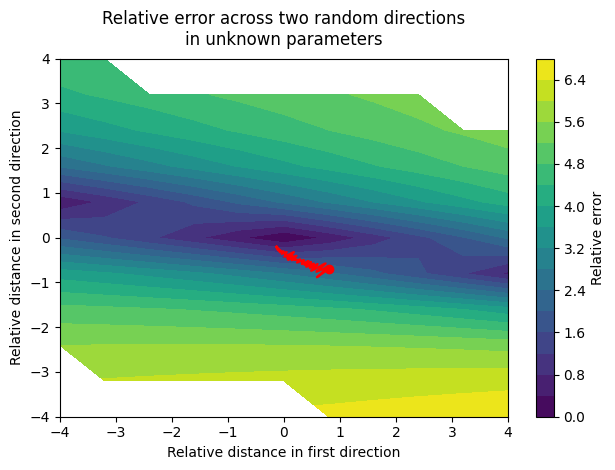

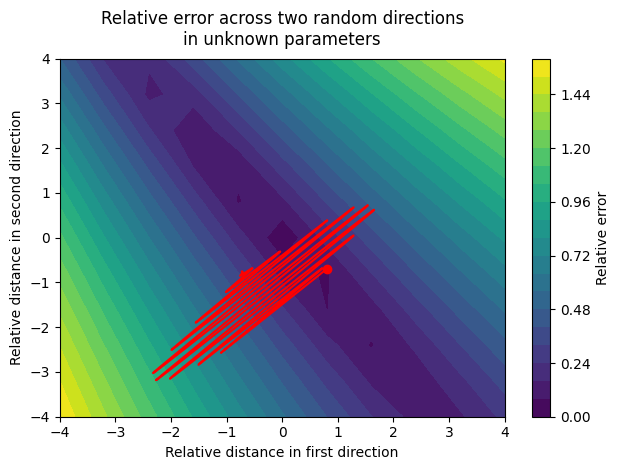

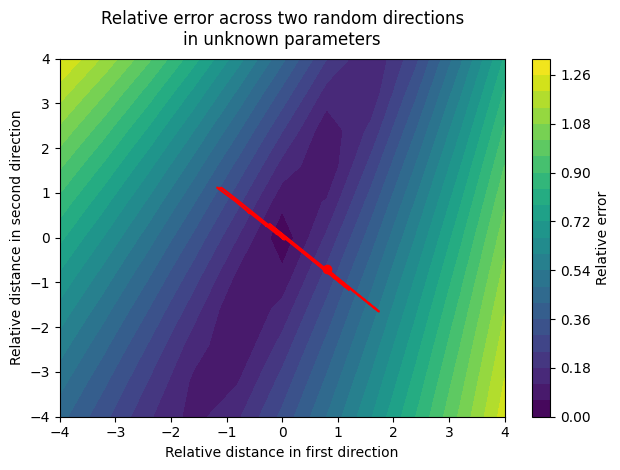

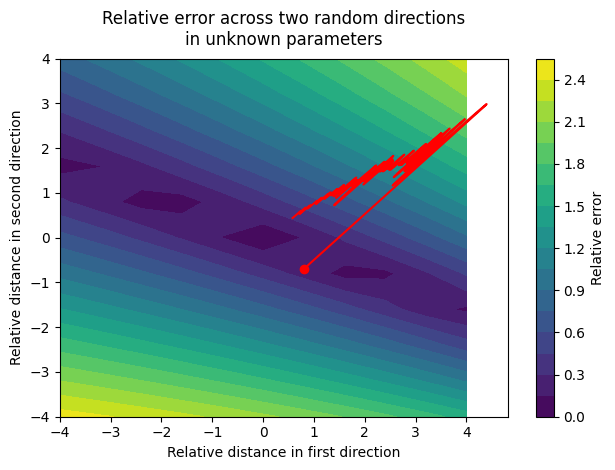

In [ ]:
for i, (surface_result, trajectory_result) in enumerate(
    zip(surface_results, trajectory_results)
):
    fig, ax = plt.subplots(1, 1)

    errors, xls, yls = surface_result
    es.plot_surface(fig, ax, errors, xls, yls)

    _, cs_coordinates = trajectory_result
    es.plot_trajectory(fig, ax, cs_coordinates)

    ax.set_xlabel("Relative distance in first direction")
    ax.set_ylabel("Relative distance in second direction")
    ax.set_title(
        "Relative error across two random directions\nin unknown parameters",
        pad=10,
    )
    fig.tight_layout()
    fig.savefig(
        os.path.join(FIGURES_FOLDER, f"error-surface_{i:0>3}.svg"),
        format="svg",
    )